# MLP with MNIST data 

<font color = "#CC3D3D"><p>
- [Module Import](#Module-Import)
- [Device Checking](#Device-Checking)
- [Data Downloading](#Data-Downloading)
- [Build Model](#Build-Model)
- [Model Train, Test](#Model-Train,-Test)
- [참고](#참고:-함수-정의를-하지-않고-train,-test-구현-+-model-저장)

## Module Import

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torchvision import transforms, datasets
import torch.nn.init as init
import random

## Device Checking 

In [8]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version: ', torch.__version__, 'DEVICE:', DEVICE)

Using PyTorch version:  1.8.0 DEVICE: cuda


In [9]:
# 한줄로 구현하기 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
# for reproducibility
random.seed(111)
torch.manual_seed(777)
if DEVICE == 'cuda':
    torch.cuda.manual_seed_all(777)

## Data Downloading 

In [11]:
BATCH_SIZE = 32
EPOCHS = 10

In [13]:
train_dataset = datasets.MNIST(root = "../data/MNIST", # 데이터를 다운받을 폴더 생성
                               train = True,    # train데이터로 다운 
                               download = True, # download 받을지 여부 결정 
                               transform = transforms.ToTensor()) # 데이터를 텐서 형태로 transforms

test_dataset = datasets.MNIST(root = "../data/MNIST",
                              train = False, # test 데이터로 다운 
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True) # 데이터를 섞어서 불러올지 여부

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Using downloaded and verified file: ../data/MNIST\MNIST\raw\train-images-idx3-ubyte.gz
Extracting ../data/MNIST\MNIST\raw\train-images-idx3-ubyte.gz to ../data/MNIST\MNIST\raw
Using downloaded and verified file: ../data/MNIST\MNIST\raw\train-labels-idx1-ubyte.gz
Extracting ../data/MNIST\MNIST\raw\train-labels-idx1-ubyte.gz to ../data/MNIST\MNIST\raw
Using downloaded and verified file: ../data/MNIST\MNIST\raw\t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data/MNIST\MNIST\raw



Extracting ../data/MNIST\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data/MNIST\MNIST\raw
Processing...


C:\Users\leeji\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


#### 데이터가 잘 다운로딩 되었는지 확인! 

In [14]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


#### 실제 MLP 데이터 확인

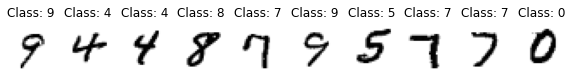

In [15]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

## Build Model 

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.batch_norm1 = nn.BatchNorm1d(512) # 데이터 정규화 
        
        self.fc2 = nn.Linear(512, 256)
        self.batch_norm2 = nn.BatchNorm1d(256)
        
        self.fc3 = nn.Linear(256, 10)
        
        self.dropout_prob = 0.5 # 과적합을 막기위한 방법 중 하나 
        
        

    def forward(self, x):
        x = x.view(-1, 28 * 28) # reshape
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x) # 활성화 함수 
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [17]:
# Optimizer, Objective Function, weight init 설정 

def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight.data)

model = Net().to(DEVICE)
model.apply(weight_init)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) # 옵티마이저 
criterion = nn.CrossEntropyLoss() # 비용함수 

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


## Model Train, Test 

#### 학습하는 함수를 정의한다. 

In [18]:
def train(model, train_loader, optimizer, log_interval):
    model.train() # train을 하겠다고 선언해준다. 
    
    for batch_idx, (image, label) in enumerate(train_loader):
        # image 와 label 을 장치에 할당해줌
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        
        # zero the parameter gradients 
        optimizer.zero_grad()
        
        # forward + backward + optimize 
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step() # 업데이트한 가중치 적용한다는 느낌

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

#### 테스트하는 함수를 정의한다. 

In [19]:
def evaluate(model, test_loader):
    model.eval() # 평가를 한다고 선언해준다. 
    test_loss = 0
    correct = 0

    with torch.no_grad(): # gradient를 업데이트 하지 않음을 설정 
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            # prediction.eq(label) --> 예측값과 정답이 같으면 1, 다르면 0 출력
            # label.view_as(prediction) --> 정답의 형태를 예측값의 형태로 만들어줌
            # .item() --> 스칼라 값을 출력해줌.
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

#### 학습, 테스트 진행 

In [20]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 3.118372
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.338720
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.211605
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.156303
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.248946
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.206331
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.268376
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.327343
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.215126
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.311527

[EPOCH: 1], 	Test Loss: 0.0042, 	Test Accuracy: 96.04 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.111723
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.432717
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.069159
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.162361
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.578344
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.364064
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.116240
T

##  참고: 함수 정의를 하지 않고 train, test 구현 + model 저장

In [21]:
def acc_check(net, test_set, epoch, save=1):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_set:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    acc = (100 * correct / total)
    print('Accuracy of the network on the 10000 test images: %d %%' % acc)
    if save:
        torch.save(net.state_dict(), "./model/model_epoch_{}_acc_{}.pth".format(epoch, int(acc)))
    return acc

In [23]:
print(len(trainloader))
epochs = 150

for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, (image,labels) in enumerate(trainloader, 0):
        # get the inputs
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() # loss.item() 은 loss 의 스칼라 값 
        if i % 30 == 29:    # print every 30 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 30))
            running_loss = 0.0
    
    #Check Accuracy
    acc = acc_check(model, testloader, epoch, save=1)
    

print('Finished Training')

1875


NameError: name 'trainloader' is not defined

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))